### DATA COLLECTION

In [12]:
# Necessary Imports
from flask import Flask, jsonify
from werkzeug.routing import IntegerConverter
from _csv import Dialect as _Dialect
import copy
import csv
import os
from lib.rtls_slave import pixel_calculate, aoa_main
import json

# Handle Negative Values
class SignedIntConverter(IntegerConverter):
    regex = r'-?\d+'
app = Flask(__name__)
app.url_map.converters['signed_int'] = SignedIntConverter
#Store input values: AoA and Horizontal Angle

aoabefore = {}
aoa= {}
lev = []

@app.route('/')
def home():
    return "This is the HomePage"

#Routing Settings
@app.route('/send/<signed_int:horiz>', methods=['GET'])
def get_angle(horiz):
    global aoa
    global aoabefore
    
    print("Plane Angle: " + str(horiz))
    aoa_result = aoa_main()
    print(aoa_result)
    input_letter = input("If you want to add this data to list type 'y', otherwise press Enter")
    if input_letter!='y':
        return jsonify({'state':'Try Again'})
    lev.append(horiz)
    aoabefore = copy.deepcopy(aoa)
    aoa = aoa_result

    with open(f"./data/aoa_results/random_{horiz}.json",'w') as f:
        json.dump(aoa_result, f)
        
    return jsonify({'state': 'success'})

@app.route('/calculate/', methods=['GET'])
def calculate():

    u = []
    v = []

    # ANGLE SORTING TECHNIQUES
    aoabefore_ = KNN_sorting(aoabefore,filter_percent=50)
    aoa_ = KNN_sorting(aoa,filter_percent=50)

    print("Before Turning："+str(aoabefore)+'\n'+"After Turning： " + str(aoa) +'\n'+"Rotation Angle： "+ str(lev))
    set_aoa = set(aoa_)
    set_aoabefore = set(aoabefore_)

    for slave in set_aoa.intersection(set_aoabefore):
        f = open(f"./results/pixels/{slave.replace(':','_')}.csv",'w',newline="")
        f.truncate()
        writer = csv.writer(f)
        
        for i in range(len(aoabefore_[slave])):
            for j in range(len(aoa_[slave])):
                (temp1, temp2) = pixel_calculate(lev[-2] - lev[-1], aoabefore_[slave][i], aoa_[slave][j])

                if (temp1 != 1):
                    u.append(temp1)
                    v.append(temp2)
                    tupx = (temp1,temp2)
                    writer.writerow(tupx)
                
        
        f.close()

    
    return jsonify({'state': 'success'})

In [ ]:
app.run(host='0.0.0.0',port = 5000, debug=False)

### POST POINT CALCULATION

In [5]:
from lib.rtls_slave import post_calculation

# POST-ANALYSIS
post_calculation('two_down_indoor',71,75)

Before Turning：{'80:6F:B0:EE:9C:67': array([-1.5, -0.5, -0.5, -1. , -0.5, -0.5, -2. , -0.5, -0.5, -2. , -1. ,
       -0.5, -0.5,  0. , -1.5, -1. , -2.5, -2. , -0.5, -2. , -2.5]), '80:6F:B0:EE:AA:13': array([19. , 18. , 19. , 19.5, 19. , 19. , 20. , 20. , 20. , 19.5, 18. ,
       19.5, 19. , 17.5, 17.5, 17.5, 17.5, 18. , 18. , 19. , 18.5, 19. ,
       18.5])}
After Turning： {'80:6F:B0:EE:AA:13': array([8. , 8. , 8. , 8.5, 9. , 8.5, 9. , 9.5, 8.5, 8. , 7.5, 8.5, 9. ,
       8. , 9. , 9.5, 8.5, 7.5, 7. , 7. , 7.5, 7. , 7.5, 8.5, 8. , 7. ]), '80:6F:B0:EE:9C:67': array([ 0. ,  0.5, -1. ,  0.5, -1. , -0.5, -0.5, -2. ,  0. , -1.5, -1.5,
       -3. , -3. , -0.5, -1.5, -1. , -2. , -1.5,  1. , -0.5, -0.5, -1. ,
       -1. ])}
Rotation Angle： [71, 75]


f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:270: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))


### VISUALIZING THE ANGLE

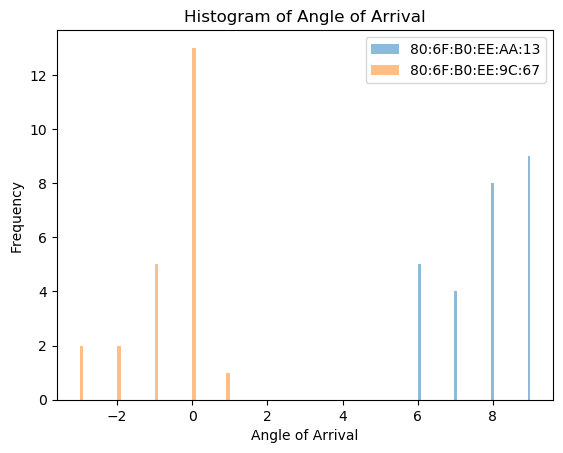

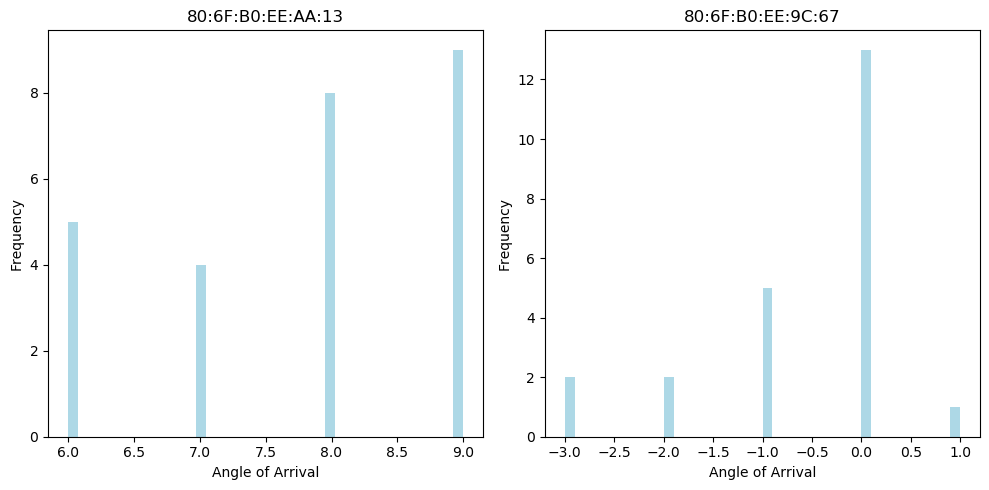

'SUCESS'

In [5]:
from lib.rtls_slave import visualize_aoa_spread

CASE = 'two_down_indoor'
level = 75
n_bins = 40
visualize_aoa_spread(CASE, level, n_bins)

In [ ]:
from lib.rtls_slave import visualize_aoa_turn_spread

CASE = 'two_top_indoor'
level1 = 68
level2 = 76
vis_bias = 0
nbins = 20

visualize_aoa_turn_spread(CASE, level1, level2, vis_bias, nbins)